In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def best_response(state, game_states, score_func):
    """
    For a given state, returns (best_moves, best_score) where best_moves is a list
    of moves that yield the highest score for player 2 (using score_func(state, candidate)).
    """
    best_moves = []
    best_score = None
    for candidate in game_states:
        _, score2 = score_func(state, candidate)
        if best_score is None or score2 > best_score:
            best_score = score2
            best_moves = [candidate]
        elif score2 == best_score:
            best_moves.append(candidate)
    return best_moves, best_score if best_score is not None else 0

def create_game_network(game_states, score_func):
    """
    Constructs a directed graph where each node (converted to str) is a game state.
    For each state, adds an edge to its best responses with 'weight' equal to the 
    best response score rounded to 2 decimals.
    """
    G = nx.DiGraph()
    for state in game_states:
        G.add_node(str(state))
    for state in game_states:
        best_moves, best_score = best_response(state, game_states, score_func)
        best_score = round(best_score, 2)
        for move in best_moves:
            G.add_edge(str(state), str(move), weight=best_score)
    return G

def visualize_game_network(G, layout="spring"):
    """
    Visualizes the directed graph with several layout options.
    
    Parameters:
      - G: The networkx DiGraph.
      - layout: Layout type. Options are 'spring', 'circular', 'shell', or 'spectral'.
      
    The arrow widths are scaled by the edge 'weight' (best response score) and 
    edges are labeled with the score (rounded to 2 decimals). Arrows are drawn with
    partial transparency.
    """
    if layout == "circular":
        pos = nx.circular_layout(G)
    elif layout == "shell":
        pos = nx.shell_layout(G)
    elif layout == "spectral":
        pos = nx.spectral_layout(G)
    else:
        pos = nx.spring_layout(G, k=1, iterations=50)
    
    plt.figure(figsize=(8, 6))
    
    nx.draw_networkx_nodes(G, pos, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    edges = G.edges(data=True)
    scaled_weights = [max(1, edata.get('weight', 1) * 2) for _, _, edata in edges]
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, width=scaled_weights, alpha=0.6)
    
    edge_labels = {(u, v): f"{edata.get('weight', 1):.2f}" for u, v, edata in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    plt.title(f"Game Move Network: Best Responses ({layout.capitalize()} Layout)")
    plt.axis('off')
    plt.show()

# --- Prisoner's Dilemma Example ---
def pd_score(move1, move2):
    """
    Prisoner's Dilemma payoff function.
    Moves: "cooperate" or "defect"
    Typical payoffs:
      - Both cooperate: (3, 3)
      - One defects, one cooperates: (0, 5) for (cooperate, defect) respectively
      - Both defect: (1, 1)
    """
    if move1 == "cooperate" and move2 == "cooperate":
        return (3, 3)
    elif move1 == "cooperate" and move2 == "defect":
        return (0, 5)
    elif move1 == "defect" and move2 == "cooperate":
        return (5, 0)
    elif move1 == "defect" and move2 == "defect":
        return (1, 1)
    return (0, 0)

if __name__ == "__main__":
    pd_moves = ["cooperate", "defect"]
    G_pd = create_game_network(pd_moves, pd_score)
    
    # Try different layouts by changing the 'layout' parameter.
    for layout in ["spring", "circular", "shell", "spectral"]:
        visualize_game_network(G_pd, layout=layout)


In [ ]:
# --- Example usage ---
# A simple Rock-Paper-Scissors scoring function.
def rps_score(move1, move2):
    """
    Returns a tuple (score1, score2) for two moves.
    In Rock-Paper-Scissors:
      - Rock beats Scissors.
      - Scissors beats Paper.
      - Paper beats Rock.
      - A tie results in (0, 0).
    """
    if move1 == move2:
        return (0, 0)
    wins = {"rock": "scissors", "paper": "rock", "scissors": "paper"}
    if wins[move1] == move2:
        return (1, 0)
    elif wins[move2] == move1:
        return (0, 1)
    return (0, 0)

if __name__ == "__main__":
    moves = ["rock", "paper", "scissors"]
    G = create_game_network(moves, rps_score)
    visualize_game_network(G)

In [3]:
C = np.array([1, 0]) # |C>
D = np.array([0, 1]) # |D>

# U(θ, φ); return a 2x2 nparray
def U(theta: float, phi: float):
    uni = np.array([[np.exp(1j * phi) * np.cos(theta/2), np.sin(theta/2)],
                    [-np.sin(theta/2), np.exp(-1j * phi) * np.cos(theta/2)]])
    return uni
#done in roughly 19 minutes; most of the time was just spent looking up syntax

#Define Operators/strategies
C_op = U(0, 0)
D_op = U(np.pi, 0)
Q_op = U(0, np.pi/2)

def R(theta):
    c = np.cos(theta)
    s = np.sin(theta)
    np.array([[c,s],[-s,c]])

#get final state vector; should return 4x1 array (complex)
#48 minutes; @ not * and forgot conj()
def final_state(U_A: np.ndarray, U_B: np.ndarray, J: np.ndarray, initial_state: np.ndarray):
    U_A = np.array(U_A)
    U_B = np.array(U_B)
    fs_vect = J.conj().transpose() @ np.kron(U_A, U_B) @ J @ initial_state
    return fs_vect

#Alice's payoff; return a float
#24 minutes;
def payoff_A(final_state: np.ndarray):

    reward = np.array([3,0,5,1])
    
    return np.abs(final_state)**2@reward

def payoff_B(final_state: np.ndarray):

    reward = np.array([3,5,0,1])
    
    return np.abs(final_state)**2@reward

def total_payoff(final_state: np.ndarray):

    
    return payoff_A(final_state)+payoff_B(final_state)

def q_del_score(u1,u2):
    
    # Maximum entanglement operator (gamma = π/2)
    entanglement_operator = J(np.pi/2)
    
    # Initial state: tensor product of |C> for Alice and |C> for Bob
    initial_state = np.kron(C, C)
    
    # Compute the final state after applying entanglement, strategies, and disentanglement
    final = final_state(u1, u2, entanglement_operator, initial_state)

    print(final)
    # Calculate Alice's expected payoff from the final state
    print(payoff_A(final),payoff_B(final))
    print()
    # Return the negative payoff (useful for minimization routines)
    return (payoff_A(final),payoff_B(final))


In [4]:
import numpy as np

# Define Pauli matrices
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# Define the quaternion group Q8
Q8 = [
    np.eye(2),      # Identity
    -np.eye(2),     # -Identity
    1j * X,        # iX
    -1j * X,       # -iX
    1j * Y,        # iY
    -1j * Y,       # -iY
    1j * Z,        # iZ
    -1j * Z        # -iZ
]

In [17]:
np.linalg.det(C_op)

np.complex128(1+0j)

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
3.0 3.0

[-1.+0.j  0.+0.j  0.+0.j  0.+0.j]
3.0 3.0

[0.+0.j 0.+1.j 0.+0.j 0.+0.j]
0.0 5.0

[0.+0.j 0.-1.j 0.+0.j 0.+0.j]
0.0 5.0

[ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
0.0 5.0

[0.+0.j 1.+0.j 0.+0.j 0.+0.j]
0.0 5.0

[0.+1.j 0.+0.j 0.+0.j 0.+0.j]
3.0 3.0

[0.-1.j 0.+0.j 0.+0.j 0.+0.j]
3.0 3.0

[-1.+0.j  0.+0.j  0.+0.j  0.+0.j]
3.0 3.0

[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
3.0 3.0

[0.+0.j 0.-1.j 0.+0.j 0.+0.j]
0.0 5.0

[0.+0.j 0.+1.j 0.+0.j 0.+0.j]
0.0 5.0

[0.+0.j 1.+0.j 0.+0.j 0.+0.j]
0.0 5.0

[ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
0.0 5.0

[0.-1.j 0.+0.j 0.+0.j 0.+0.j]
3.0 3.0

[0.+1.j 0.+0.j 0.+0.j 0.+0.j]
3.0 3.0

[0.+0.j 0.+0.j 0.+1.j 0.+0.j]
5.0 0.0

[0.+0.j 0.+0.j 0.-1.j 0.+0.j]
5.0 0.0

[ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]
1.0 1.0

[0.+0.j 0.+0.j 0.+0.j 1.+0.j]
1.0 1.0

[0.+0.j 0.+0.j 0.+0.j 0.-1.j]
1.0 1.0

[0.+0.j 0.+0.j 0.+0.j 0.+1.j]
1.0 1.

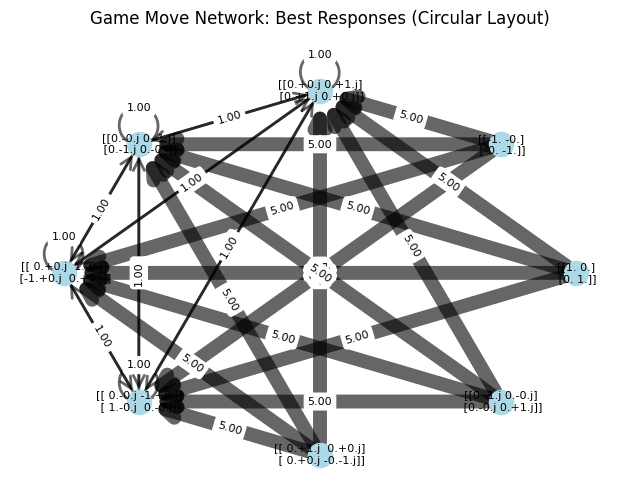

NameError: name 'visualize_payoff_grid_split' is not defined

In [6]:
# --- Example usage ---
# A simple Rock-Paper-Scissors scoring function.
#gamma within the range 0 -> pi/2; entanglement increases as gamma increases
#Get unitary Operator J; 9 minutes
def J(gamma):
    return expm(np.kron(-1j*gamma*C_op,C_op/2))
    
if __name__ == "__main__":
    j = J(np.pi/4)
    print(np.round(j.dot(j.conj().T),3))
    moves = Q8
    G = create_game_network(moves, q_del_score)
    visualize_game_network(G,layout="circular")
    visualize_payoff_grid_split(moves, q_del_score)

In [38]:
reward = np.array([3,5,0,1])
final_state = np.array([-2.30129890e+00+1.49028426e-33j,  1.84889275e-32-2.50917848e+00j,
  0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j])
np.abs(final_state)**2

# @reward

array([5.29597663, 6.29597664, 0.        , 0.        ])

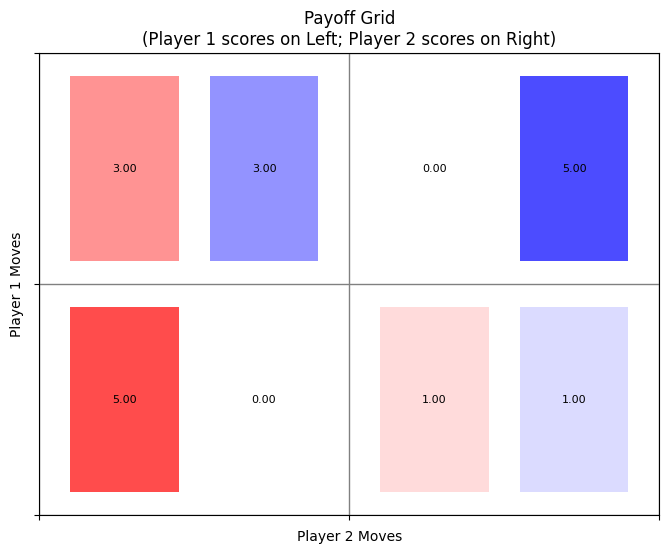

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_payoff_grid_split(game_states, score_func):
    """
    Creates a grid where each cell (i, j) corresponds to:
      - Player1's move: game_states[i] (rows)
      - Player2's move: game_states[j] (columns)
    
    Inside each cell, a small square is split into two halves:
      - Left half: colored in red shades proportional to Player1's score.
      - Right half: colored in blue shades proportional to Player2's score.
      
    Each half is annotated with the respective score (rounded to 2 decimals).
    """
    n = len(game_states)
    score1_matrix = np.zeros((n, n))
    score2_matrix = np.zeros((n, n))
    
    # Compute payoff matrices.
    for i, move1 in enumerate(game_states):
        for j, move2 in enumerate(game_states):
            s1, s2 = score_func(move1, move2)
            score1_matrix[i, j] = s1
            score2_matrix[i, j] = s2
            
    # Normalization factors (avoid division by zero).
    max1 = np.max(score1_matrix) if np.max(score1_matrix) != 0 else 1
    max2 = np.max(score2_matrix) if np.max(score2_matrix) != 0 else 1

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(0, n)
    ax.set_ylim(0, n)
    ax.invert_yaxis()  # so that row 0 is at the top.
    
    # Set tick labels.
    ax.set_xticks(np.arange(n) + 0.5)
    ax.set_yticks(np.arange(n) + 0.5)
    ax.set_xticklabels([str(m) for m in game_states])
    ax.set_yticklabels([str(m) for m in game_states])
    ax.set_xlabel("Player 2 Moves")
    ax.set_ylabel("Player 1 Moves")
    
    # Draw grid lines.
    ax.set_xticks(np.arange(n+1))
    ax.set_yticks(np.arange(n+1))
    ax.grid(which='both', color='gray', linestyle='-', linewidth=1)

    # For each cell, draw an internal split square.
    for i in range(n):
        for j in range(n):
            # Normalized intensities.
            intensity1 = score1_matrix[i, j] / max1
            intensity2 = score2_matrix[i, j] / max2
            
            # Define a small internal square inside the cell.
            cell_left = j + 0.1
            cell_top = i + 0.1
            cell_width = 0.8
            cell_height = 0.8
            
            # Left half (Player1): red color with intensity.
            left_width = cell_width/2 - 0.05
            left_rect = patches.Rectangle((cell_left, cell_top), left_width, cell_height,
                                          facecolor=(1, 1 - intensity1, 1 - intensity1),
                                          edgecolor='none', alpha=0.7)
            # Right half (Player2): blue color with intensity.
            right_width = cell_width/2 - 0.05
            right_rect = patches.Rectangle((cell_left + cell_width/2 + 0.05, cell_top),
                                           right_width, cell_height,
                                           facecolor=(1 - intensity2, 1 - intensity2, 1),
                                           edgecolor='none', alpha=0.7)
            ax.add_patch(left_rect)
            ax.add_patch(right_rect)
            
            # Annotate the halves with their scores.
            ax.text(cell_left + left_width/2, cell_top + cell_height/2,
                    f"{score1_matrix[i, j]:.2f}", ha='center', va='center', fontsize=8, color='black')
            ax.text(cell_left + cell_width/2 + 0.05 + right_width/2, cell_top + cell_height/2,
                    f"{score2_matrix[i, j]:.2f}", ha='center', va='center', fontsize=8, color='black')
    
    plt.title("Payoff Grid\n(Player 1 scores on Left; Player 2 scores on Right)")
    plt.show()


# --- Prisoner's Dilemma Example ---
def pd_score(move1, move2):
    """
    Prisoner's Dilemma payoff:
      - Both cooperate: (3, 3)
      - One cooperates while the other defects: (0, 5) for (cooperate, defect)
      - Both defect: (1, 1)
    """
    if move1 == "cooperate" and move2 == "cooperate":
        return (3, 3)
    elif move1 == "cooperate" and move2 == "defect":
        return (0, 5)
    elif move1 == "defect" and move2 == "cooperate":
        return (5, 0)
    elif move1 == "defect" and move2 == "defect":
        return (1, 1)
    return (0, 0)

if __name__ == "__main__":
    moves = ["cooperate", "defect"]
    visualize_payoff_grid_split(moves, pd_score)
